# SNES tests

Tests for the SNES implementation in PINTS.

We start by visually inspecting its behaviour on selected problems.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from plotnine import *

import pints
import pints.toy
import pints.cptests.xnes as cp

from utils import (
    function,
    function_between_points,
    technicolor_dreamline,
    run_replicates,
)

method = pints.SNES
parallel = True

## Logistic model - no transformations


In [2]:
model = pints.toy.LogisticModel()

xtrue = model.suggested_parameters()
times = model.suggested_times()
values = model.simulate(xtrue, times)
values += np.random.normal(0, 5, values.shape)
problem = pints.SingleOutputProblem(model, times, values)

error = pints.SumOfSquaresError(problem)
xlim = [0, 0.5]
ylim = [10, 100]
boundaries = pints.RectangularBoundaries(
    [xlim[0], ylim[0]], [xlim[1], ylim[1]])

x0 = boundaries.sample(1)[0]

In [3]:
controller = pints.OptimisationController(
    error, x0, boundaries=boundaries, method=method)
controller.set_parallel(False)  # This is faster

b = pints.Timer()
xbest, fbest = controller.run()
print(b.format())

Minimising error measure
Using Seperable Natural Evolution Strategy (SNES)
Running in sequential mode.
Population size: 6
Iter. Eval. Best      Current   Time    
0     5      11202.64  11202.64   0:00.0
1     11     6505.163  6505.163   0:00.0
2     17     6505.163  7249.728   0:00.0
3     22     2519.149  2519.149   0:00.0
20    122    2351.005  2382.935   0:00.0
40    242    2348.467  2348.482   0:00.0
60    362    2348.464  2348.466   0:00.0
80    482    2348.464  2348.464   0:00.0
100   602    2348.464  2348.464   0:00.0
120   722    2348.464  2348.464   0:00.0
140   842    2348.464  2348.464   0:00.0
160   962    2348.464  2348.464   0:00.1
180   1082   2348.464  2348.464   0:00.1
200   1202   2348.464  2348.464   0:00.1
220   1322   2348.464  2348.464   0:00.1
240   1442   2348.464  2348.464   0:00.1
260   1562   2348.464  2348.464   0:00.1
280   1682   2348.464  2348.464   0:00.1
295   1766   2348.464  2348.464   0:00.1
Halting: No significant change for 200 iterations.
0.1 sec

  Found       xbest        Relative error
   9.948e-02   1.000e-01  -0.520% 
   4.964e+01   5.000e+01  -0.721% 



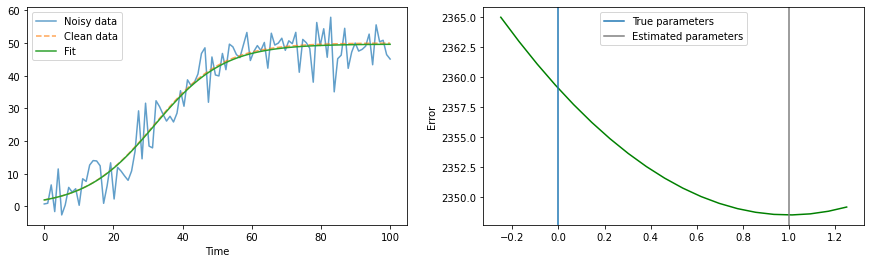

In [4]:
print('  Found       xbest        Relative error' )
for x, y in zip(xbest, xtrue):
    e = (x - y) / y    
    print(f'  {x:> 3.3e}  {y:> 3.3e}  {e:> 3.3%} ')
print()

fig = plt.figure(figsize=(15, 4))
ax = fig.add_subplot(1, 2, 1)
ax.set_xlabel('Time')
ax.set_label('Value')
ax.plot(times, values, label='Noisy data', alpha=0.7)
ax.plot(times, problem.evaluate(xtrue), '--', label='Clean data', alpha=0.7)
ax.plot(times, problem.evaluate(xbest), label='Fit')
ax.legend()
ax = fig.add_subplot(1, 2, 2)
function_between_points(ax, error, xtrue, xbest)

plt.show()

Like the other -ES methods, this converges rapidly.

### Detailed run

In [9]:
x0 = [0.4, 90]
opt = method(x0, boundaries=boundaries)
walk = [x0]
for i in range(80):
    opt.tell([error(x) for x in opt.ask()])
    walk.append(opt.x_guessed())
walk = np.array(walk)

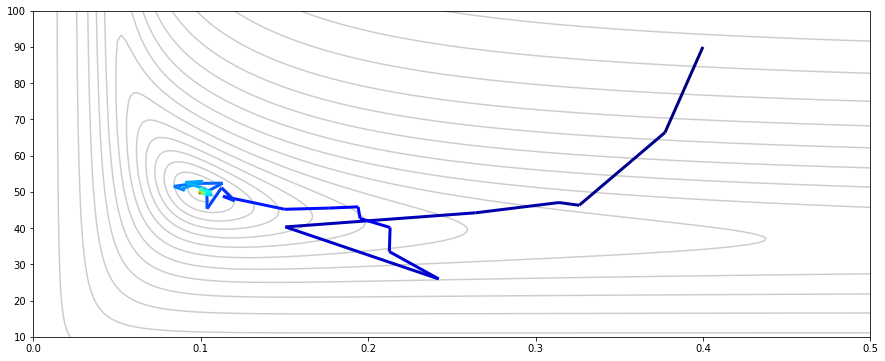

In [10]:
# Create points for contour plot of marginal density
levels = np.geomspace(1e3, 4e5, 20)
x = np.linspace(*xlim, 200)
y = np.linspace(*ylim, 150)
X, Y = np.meshgrid(x, y)
Z = [[error([i, j]) for i in x] for j in y]

# Plot contours and optimiser progress
fig = plt.figure(figsize=(15, 6))
ax = fig.add_subplot(1, 1, 1)
ax.contour(X, Y, Z, levels=levels, colors='k', alpha=0.2)
technicolor_dreamline(ax, walk[:, 0], walk[:, 1], lw=3)
ax.set_xlim(*xlim)
ax.set_ylim(*ylim)
plt.show()

Perhaps, SNES looks a bit more erratic here, due to working independently in each parameter.
But hard to check and quantify!

## Neal's funnel

In [13]:
log_pdf = pints.toy.NealsFunnelLogPDF()
x0 = 9 * np.ones(10, dtype=float)
x0[-1] = 7

opt = method(x0)
walk = [x0]
for i in range(200):
    opt.tell([-log_pdf(x) for x in opt.ask()])
    walk.append(opt.x_guessed())
walk = np.array(walk)

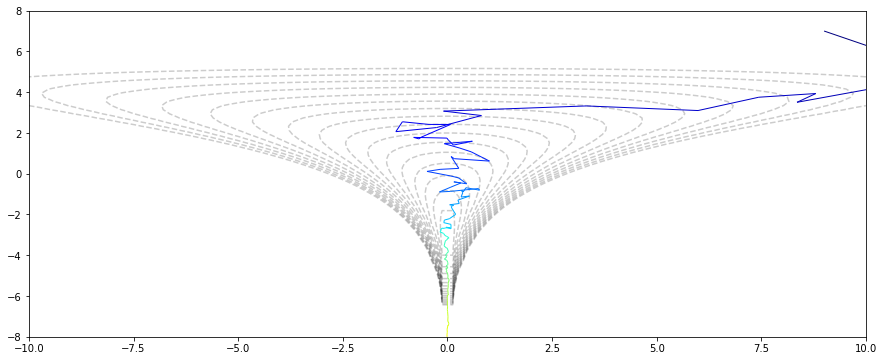

In [14]:
# Create points for contour plot of marginal density
xlim = -10, 10
ylim = -8, 8
levels = np.linspace(-7, -1, 20)
x = np.linspace(*xlim, 80)
y = np.linspace(*ylim, 80)
X, Y = np.meshgrid(x, y)
Z = [[log_pdf.marginal_log_pdf(i, j) for i in x] for j in y]

# Plot contours and optimiser progress
fig = plt.figure(figsize=(15, 6))
ax = fig.add_subplot(1, 1, 1)
ax.contour(X, Y, Z, levels=levels, colors='k', alpha=0.2)
technicolor_dreamline(ax, walk[:, 0], walk[:, 9])
ax.set_xlim(*xlim)
ax.set_ylim(*ylim)
plt.show()

SNES seems to find this problem easier than xNES and even CMA-ES.

## Rosenbrock function

The SNES method in PINTS struggles with the Rosenbrock function: It takes significantly longer than xNES and CMAES, and seems to converge very slowly in the end.

In [30]:
error = pints.toy.RosenbrockError()
x0 = [-4, -2]

opt = method(x0)
walk = [x0]
for i in range(5000):
    opt.tell([error(x) for x in opt.ask()])
    walk.append(opt.x_guessed())
walk = np.array(walk)

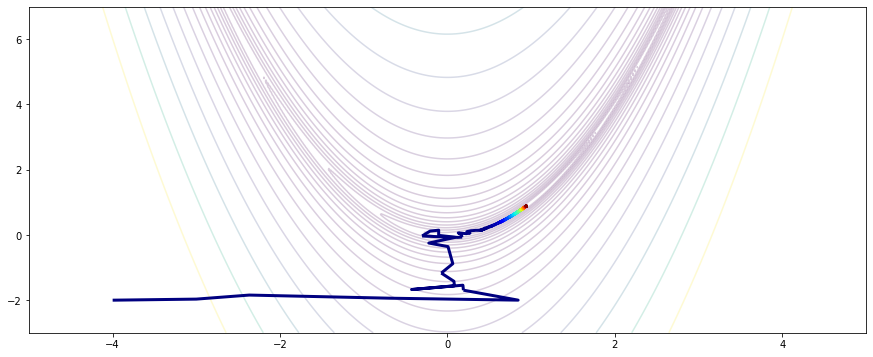

In [31]:
# Create points for contour plot of marginal density
xlim = [-5, 5]
ylim = [-3, 7]
levels = np.geomspace(1, 1e4, 20) - 1
x = np.linspace(*xlim, 400)
y = np.linspace(*ylim, 400)
X, Y = np.meshgrid(x, y)
Z = [[error([i, j]) for i in x] for j in y]

# Plot contours and optimiser progress
fig = plt.figure(figsize=(15, 6))
ax = fig.add_subplot(1, 1, 1)
ax.contour(X, Y, Z, levels=levels, cmap='viridis', alpha=0.2)
technicolor_dreamline(ax, walk[:, 0], walk[:, 1], lw=3)
ax.set_xlim(*xlim)
ax.set_ylim(*ylim)
plt.show()

Zoom view:

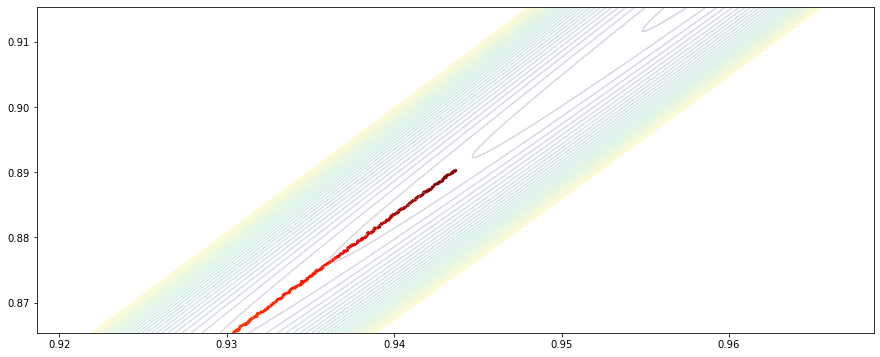

In [32]:
# Create points for contour plot of marginal density
xbest = walk[-1, :]
xlim = [xbest[0] - 0.025, xbest[0] + 0.025]
ylim = [xbest[1] - 0.025, xbest[1] + 0.025]
levels = np.geomspace(1, 1.03, 30) - 1
x = np.linspace(*xlim, 400)
y = np.linspace(*ylim, 400)
X, Y = np.meshgrid(x, y)
Z = [[error([i, j]) for i in x] for j in y]

# Plot contours and optimiser progress
fig = plt.figure(figsize=(15, 6))
ax = fig.add_subplot(1, 1, 1)
ax.contour(X, Y, Z, levels=levels, cmap='viridis', alpha=0.2)
technicolor_dreamline(ax, walk[:, 0], walk[:, 1], lw=3)
ax.set_xlim(*xlim)
ax.set_ylim(*ylim)
plt.show()

## Fitzhugh-Nagumo model - fully observable

In [33]:
model = pints.toy.FitzhughNagumoModel()

xtrue = model.suggested_parameters()
times = model.suggested_times()
values = model.simulate(xtrue, times)
r = np.random.default_rng(1)  # Create a seeded generator to get reproducible noise
values += r.normal(0, 0.5, values.shape)
problem = pints.MultiOutputProblem(model, times, values)

error = pints.SumOfSquaresError(problem)
xlim = [1e-3, 2]
ylim = [1e-3, 2]
zlim = [1e-3, 10]
boundaries = np.vstack((xlim, ylim, zlim)).T
boundaries = pints.RectangularBoundaries(boundaries[0], boundaries[1])

In [34]:
# Use a fixed starting point for this one
x0 = xtrue * 1.3

controller = pints.OptimisationController(
    error, x0, boundaries=boundaries, method=method)
controller.set_parallel(parallel)

b = pints.Timer()
xbest, fbest = controller.run()
print(b.format())

Minimising error measure
Using Seperable Natural Evolution Strategy (SNES)
Running in parallel with 7 worker processes.
Population size: 7
Iter. Eval. Best      Current   Time    
0     4      329.3903  329.3903   0:00.1
1     10     100.9225  100.9225   0:00.1
2     17     100.9225  255.1181   0:00.1
3     19     100.9225  519.6232   0:00.1
20    120    88.73052  92.60087   0:00.2
40    255    83.57013  85.9821    0:00.4
60    395    83.11863  83.1383    0:00.6
80    535    83.07397  83.07883   0:00.8
100   675    83.07207  83.07234   0:00.9
120   815    83.07149  83.07152   0:01.0
140   955    83.07144  83.07145   0:01.2
160   1095   83.07141  83.07141   0:01.4
180   1235   83.07139  83.07139   0:01.6
200   1375   83.07138  83.07138   0:01.8
220   1515   83.07137  83.07137   0:02.0
240   1655   83.07136  83.07136   0:02.1
260   1795   83.07136  83.07136   0:02.3
280   1935   83.07136  83.07136   0:02.4
300   2075   83.07136  83.07136   0:02.6
320   2215   83.07136  83.07136   0:02.7


  Found       xbest        Relative error
   8.710e-02   1.000e-01  -12.898% 
   5.738e-01   5.000e-01   14.755% 
   2.929e+00   3.000e+00  -2.376% 



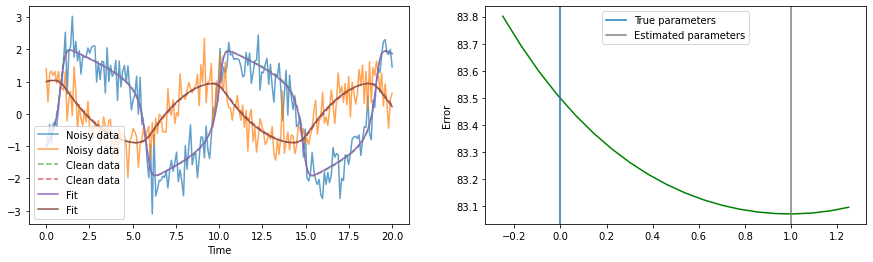

In [35]:
print('  Found       xbest        Relative error' )
for x, y in zip(xbest, xtrue):
    e = (x - y) / y    
    print(f'  {x:> 3.3e}  {y:> 3.3e}  {e:> 3.3%} ')
print()

fig = plt.figure(figsize=(15, 4))
ax = fig.add_subplot(1, 2, 1)
ax.set_xlabel('Time')
ax.set_label('Value')
ax.plot(times, values, label='Noisy data', alpha=0.7)
ax.plot(times, problem.evaluate(xtrue), '--', label='Clean data', alpha=0.7)
ax.plot(times, problem.evaluate(xbest), label='Fit')
ax.legend()
ax = fig.add_subplot(1, 2, 2)
function_between_points(ax, error, xtrue, xbest)

plt.show()

Despite finding the right solution after about 60 iterations, the optimisation continues for a long time. Again it seems the final convergence is very slow.

# Testing performance

## 2D Parabola

If this doesn't work, something is broken.

In [36]:
t = pints.Timer()
test = run_replicates(np.geomspace(1, 50, 20), 20, cp.two_dim_parabola, parallel)
print(t.format())

0.89 seconds


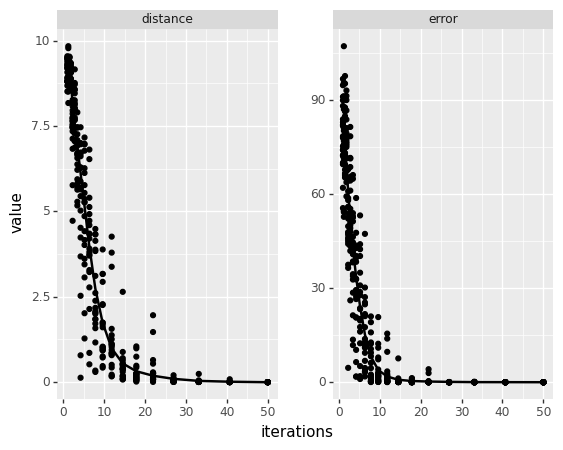

<ggplot: (8748529724993)>

In [37]:
df = pd.melt(test, id_vars=['iterations', 'replicate'])
(ggplot(df, aes(x='iterations', y='value'))
 + geom_jitter(width=0)
 + geom_smooth(span=0.25, se=False)
 + facet_wrap('variable', scales='free')
 + theme(subplots_adjust={'wspace': 0.25})
)

SNES here looks to be more consistent than xNES.

## Rosenbrock function

As convergence is slow, this seems a poor test for SNES.

## Bounded, untransformed logistic model

In [44]:
t = pints.Timer()
test = run_replicates(np.geomspace(1, 300, 30), 10, cp.bounded_untransformed_logistic, parallel)
print(t.format())

1.95 seconds


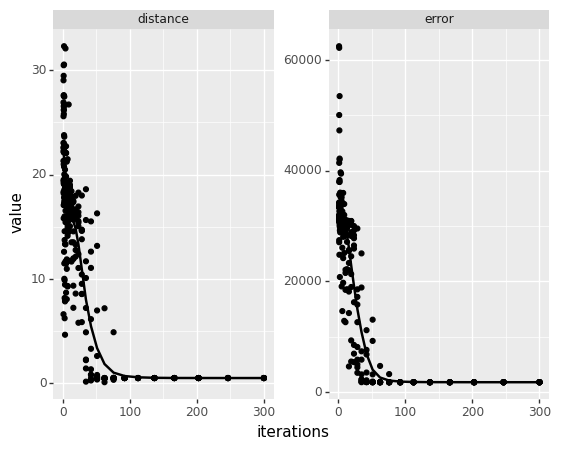

<ggplot: (8748550674393)>

In [45]:
df = pd.melt(test, id_vars=['iterations', 'replicate'])
(ggplot(df, aes(x='iterations', y='value'))
 + geom_jitter(width=0)
 + geom_smooth(span=0.3, se=False)
 + facet_wrap('variable', scales='free')
 + theme(subplots_adjust={'wspace': 0.25})
)

SNES performs very well on this problem, perhaps due to its very different parameter scales (which SNES is designed to cope well with).

## Bounded Fitzhugh-Nagumo

In [46]:
t = pints.Timer()
test = run_replicates(np.geomspace(1, 100, 10), 20, cp.bounded_fitzhugh_nagumo, parallel)
print(t.format())

14.01 seconds


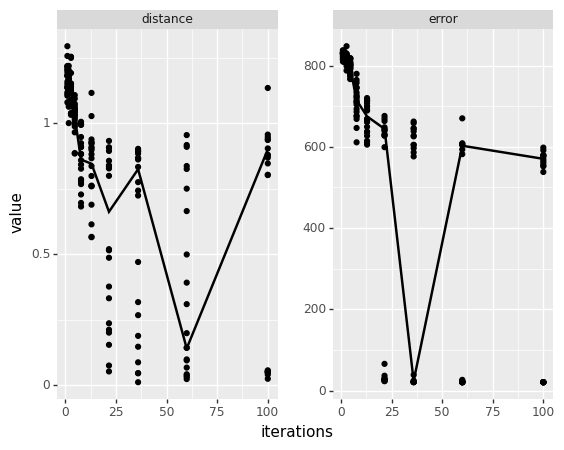

<ggplot: (8748530958145)>

In [47]:
df = pd.melt(test, id_vars=['iterations', 'replicate'])
(ggplot(df, aes(x='iterations', y='value'))
 + geom_jitter(width=0)
 + geom_smooth(span=0.3, se=False)
 + facet_wrap('variable', scales='free')
 + theme(subplots_adjust={'wspace': 0.25})
)

The all-or-nothing nature here results in a clear bimodal distribution, with most points ending up under the "nothing" peak.